### Question 2.1

#### Dataset

In [17]:
from utils import load_rnacompete_data
from utils import  configure_seed

In [18]:
# Set seed for repetibility
configure_seed(33)

In [19]:

ds_train = load_rnacompete_data("RBFOX1", split="train")
ds_val = load_rnacompete_data("RBFOX1", split="val")
ds_test = load_rnacompete_data("RBFOX1", split="test")

Found cached data for RBFOX1 (train). Loading from data/RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from data/RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from data/RBFOX1_test_data.pt...


##### CNN Implementation

Model definition

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple CNN model inspired by DeepBind (Alipanahi et al, 2015)
class CNN(nn.Module):
    
    def __init__(self, motif_len=24, num_filters=64, hidden=32, dropout=0.5):
        super().__init__()
        self.conv = nn.Conv2d(1, num_filters, kernel_size=(motif_len, 4))
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(num_filters, hidden)
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = F.relu(self.conv(x).squeeze(-1))   # (B, C, L')
        x = torch.max(x, dim=2).values         # global max pool -> (B, C)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)                        # linear output
        return x

        

In [21]:
x = torch.rand(1,1,41,4)
model = CNN().to("cpu")
out = model(x)
print(out.shape)

torch.Size([1, 1])


Training loop

In [22]:

import pickle
from torch.utils.data import DataLoader
from utils import masked_mse_loss, masked_spearman_correlation, plot


def train(model, epochs, batch_size, lr, ds_train, ds_val, weight_decay=0, verbose=True):
    """
    Trains model with specified hyperparams on given train and validation datasets.
    Saves model checkpoint to specified path. 
    """
        
    # Data loaders
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(ds_val, batch_size=len(ds_val), shuffle=False)

    # Optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Save best state
    best_state_dict = {}
    best_val_corr = 0.0
    best_epoch = 0

    # Keep track of losses 
    train_losses = []
    val_losses = []
    
    # Training loop 
    for epoch in range(epochs):
        
        train_loss = 0.0
        train_corr = 0.0
        
        # Set model to training mode
        model.train()
            
        # Loop over batches
        for x, y, mask in train_loader:
            
            # Reset optimizer
            optim.zero_grad()
            
            # Add channel dimension to x
            x = x.unsqueeze(1)
            
            # Forward pass
            y_hat = model(x)
            
            # Loss
            loss = masked_mse_loss(y_hat, y, mask)
            train_loss += loss.item()
            train_corr += masked_spearman_correlation(y_hat, y, mask).item()
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optim.step()
            
        # Average  
        train_loss /= len(train_loader)
        train_corr /= len(train_loader)
        
        train_losses.append(train_loss)
        
        # Set model to evalution mode
        model.eval()
        
        # Validation
        val_corr = 0.0
        val_loss = 0.0
        for x, y, mask in val_loader:
            
            # Add channel dimension to x 
            x = x.unsqueeze(1)
            
            # Forward pass
            y_hat = model(x)
            
            # Compute masked spearman correlation
            val_corr += masked_spearman_correlation( y_hat, y, mask).item()
            
            # Compute masked mse loss 
            val_loss += masked_mse_loss(y_hat, y, mask).item()
            
        # Average
        val_corr /= len(val_loader)
        val_loss /= len(val_loader)
        
        val_losses.append(val_loss)
        
        # Update best state
        if val_corr > best_val_corr:
            best_val_corr = val_corr
            best_state_dict = model.state_dict()
            best_epoch = epoch
            
        if verbose:
            print(f"Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss }, Val corr: {val_corr}")
      
    if verbose:  
        print(f"Best model at epoch {best_epoch} with validation spearman correlation {best_val_corr}")
    
    return best_state_dict, best_val_corr, train_losses, val_losses


In [23]:

# Device
device = "cpu"

# Model 
model = CNN().to(device)

# Train
best_state, best_val_corr, train_losses, val_losses = train(model, 
                                                            epochs=20, 
                                                            batch_size=256, 
                                                            lr=1e-3,
                                                            ds_train=ds_train,
                                                            ds_val=ds_val)

# Save best state to file
with open("q2_cnn_best.model","wb") as file:
      pickle.dump(best_state, file)
      


Epoch: 0, Train loss: 0.9285809255405193, Val loss: 0.7200647592544556, Val corr: 0.4454372525215149
Epoch: 1, Train loss: 0.6862829838649663, Val loss: 0.5943648815155029, Val corr: 0.48067793250083923
Epoch: 2, Train loss: 0.6133005802843235, Val loss: 0.5419196486473083, Val corr: 0.5001242160797119
Epoch: 3, Train loss: 0.5956559654730385, Val loss: 0.5235238075256348, Val corr: 0.5040954351425171
Epoch: 4, Train loss: 0.5908664534515664, Val loss: 0.535117506980896, Val corr: 0.5057953000068665
Epoch: 5, Train loss: 0.5781730966400405, Val loss: 0.5337967872619629, Val corr: 0.5138970613479614
Epoch: 6, Train loss: 0.5698954368934075, Val loss: 0.506610631942749, Val corr: 0.5131253600120544
Epoch: 7, Train loss: 0.5618468774013241, Val loss: 0.5147172212600708, Val corr: 0.5144901275634766
Epoch: 8, Train loss: 0.5553570099629521, Val loss: 0.5367209315299988, Val corr: 0.5148882269859314
Epoch: 9, Train loss: 0.555509128526288, Val loss: 0.5249161720275879, Val corr: 0.516670465

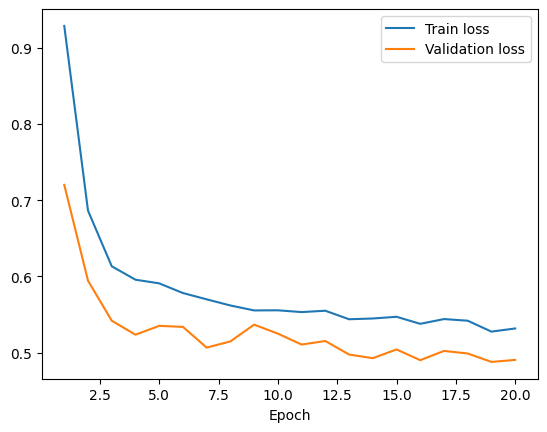

In [24]:
# Plot losses
epochs = [i+1 for i in range(20)]
plot(epochs, {"Train loss":train_losses, "Validation loss":val_losses})

Evaluate on test dataset

In [25]:

# Evaluate on test dataset
model = CNN().to(device)

# Data loader for test dataset
test_loader = DataLoader(ds_test, len(ds_test), shuffle=False)

with open("q2_cnn_best.model","rb") as file:
    model.load_state_dict(pickle.load(file))
    
test_corr = 0.0
for x, y, mask in test_loader:
        
    # Add channel dimension to x 
    x = x.unsqueeze(1)
    
    # Compute spearman correlation
    test_corr = masked_spearman_correlation( model(x), y, mask)
    
    # Break (single batch)
    break

print(f"Spearman correlation on test set is {test_corr}")
    


Spearman correlation on test set is 0.4615493416786194


Hyperparameters tuning

In [26]:

# Reconfigure seed
configure_seed(33)

# Grid
lr_vals = [1e-2, 1e-3, 1e-4]
wd_vals = [0, 1e-5]
dropout_vals = [0.3, 0.5]

# Keep track of best model in grid
best_model = {"val_corr":0}

# Device
device = "gpu" if torch.cuda.is_available() else "cpu"
            
# Grid searcg
for lr in lr_vals:
    for weight_decay in wd_vals:
        for dropout in dropout_vals:
            
            print(f"Combination: lr {lr}, weight decay {weight_decay}, dropout {dropout}")
            
            # Instantiate model
            model = CNN(dropout=dropout).to(device)
            
            # Train
            best_state, best_val_corr, train_losses, val_losses = train(model, 
                                                                        epochs=20, 
                                                                        batch_size=256, 
                                                                        lr=lr,
                                                                        ds_train=ds_train,
                                                                        ds_val=ds_val,
                                                                        weight_decay=weight_decay,
                                                                        verbose=False)
                                            
            print(f"Best validation correlation: {best_val_corr}")
            print("____________")
            
            if  best_val_corr > best_model["val_corr"]:
                best_model["val_corr"] = best_val_corr
                best_model["state"] = best_state
                best_model["train_losses"] = train_losses
                best_model["val_losses"] = val_losses
                best_model["config"] = (lr, weight_decay, dropout)

Combination: lr 0.01, weight decay 0, dropout 0.3
Best validation correlation: 0.5073546171188354
____________
Combination: lr 0.01, weight decay 0, dropout 0.5
Best validation correlation: 0.4743407964706421
____________
Combination: lr 0.01, weight decay 1e-05, dropout 0.3
Best validation correlation: 0.5039880871772766
____________
Combination: lr 0.01, weight decay 1e-05, dropout 0.5
Best validation correlation: 0.4546607732772827
____________
Combination: lr 0.001, weight decay 0, dropout 0.3
Best validation correlation: 0.5504807233810425
____________
Combination: lr 0.001, weight decay 0, dropout 0.5
Best validation correlation: 0.5238093733787537
____________
Combination: lr 0.001, weight decay 1e-05, dropout 0.3
Best validation correlation: 0.5472891926765442
____________
Combination: lr 0.001, weight decay 1e-05, dropout 0.5
Best validation correlation: 0.5219714045524597
____________
Combination: lr 0.0001, weight decay 0, dropout 0.3
Best validation correlation: 0.498661905

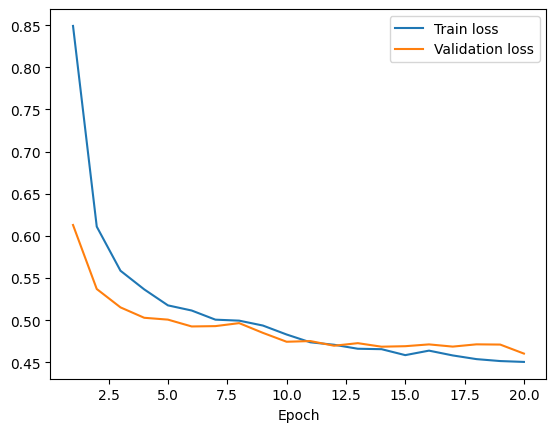

In [27]:
# Plots 
epochs = [i+1 for i in range(20)]

plot(epochs, {"Train loss":best_model["train_losses"], "Validation loss":best_model["val_losses"]})

In [28]:
# Evaluate on test dataset
model = CNN().to(device)

# Data loader for test dataset
test_loader = DataLoader(ds_test, len(ds_test), shuffle=False)

model.load_state_dict(best_model["state"])
    
test_corr = 0.0
for x, y, mask in test_loader:
        
    # Add channel dimension to x 
    x = x.unsqueeze(1)
    
    # Compute spearman correlation
    test_corr = masked_spearman_correlation( model(x), y, mask)
    
    # Break (single batch)
    break

print(f"Spearman correlation on test set is {test_corr}")
    


Spearman correlation on test set is 0.45041775703430176


##### RNN Implementation

Model definition

In [8]:

import torch
import torch.nn as nn 
import torch.nn.functional as F 

# Simple RNN inspired by DeeperBind (2016)
class RNN(nn.Module):
    
    def __init__(
        self,        
        motif_len: int = 11,           
        conv_out_ch: int = 32,         # number of motif detectors 
        lstm_hidden_size: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.5
    ):
        super().__init__()

        # Single convolutional motif detector bank 
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=conv_out_ch,
            kernel_size=(motif_len, 4)
        )

        # Stacked LSTM over the sequence of conv features
        self.lstm = nn.LSTM(
            input_size=conv_out_ch,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        # Small MLP head (
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # Conv + ReLU -> (B, C, T, 1) then squeeze -> (B, C, T)
        z = F.relu(self.conv(x).squeeze(-1))

        # Prepare for LSTM: (B, T, C)
        v = z.transpose(1, 2).contiguous()

        # LSTM over positions
        out, _ = self.lstm(v)          # out: (B, T, H)

        # Take last timestep of lstm
        h = out[:, -1, :]              # (B, H)

        # MLP head (linear output for regression)
        h = self.dropout(h)
        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        y = self.fc2(h)                # (B, 1)

        return y



In [2]:
x = torch.rand(1,1,41,4)
model = RNN().to("cpu")

out = model(x)

Training loop

In [ ]:
# Device
device = "cpu"

# Model 
model = RNN().to(device)

# Train
best_state, best_val_corr, train_losses, val_losses = train(model, 
                                                            epochs=20, 
                                                            batch_size=256, 
                                                            lr=1e-3,
                                                            ds_train=ds_train,
                                                            ds_val=ds_val)

# Save best state to file
with open("q2_rnn_best.model","wb") as file:
      pickle.dump(best_state, file)
      


Epoch: 0, Train loss: 0.902095365903738, Val loss: 0.7430113554000854, Val corr: 0.4135299026966095
Epoch: 1, Train loss: 0.6755943953279475, Val loss: 0.6378597617149353, Val corr: 0.42308562994003296
Epoch: 2, Train loss: 0.5491821579733958, Val loss: 0.5463371276855469, Val corr: 0.5078349709510803
Epoch: 3, Train loss: 0.5267552715239537, Val loss: 0.502980649471283, Val corr: 0.5184303522109985
Epoch: 4, Train loss: 0.5088092293442086, Val loss: 0.49581030011177063, Val corr: 0.526989758014679
Epoch: 5, Train loss: 0.49806357252186745, Val loss: 0.6196520924568176, Val corr: 0.5168223977088928
Epoch: 6, Train loss: 0.507516625072975, Val loss: 0.46322959661483765, Val corr: 0.5402454733848572
Epoch: 7, Train loss: 0.48988270245749377, Val loss: 0.4604647755622864, Val corr: 0.5443205237388611
Epoch: 8, Train loss: 0.4645688888920713, Val loss: 0.5256562829017639, Val corr: 0.5306208729743958
Epoch: 9, Train loss: 0.4617033782625072, Val loss: 0.4447021782398224, Val corr: 0.553122

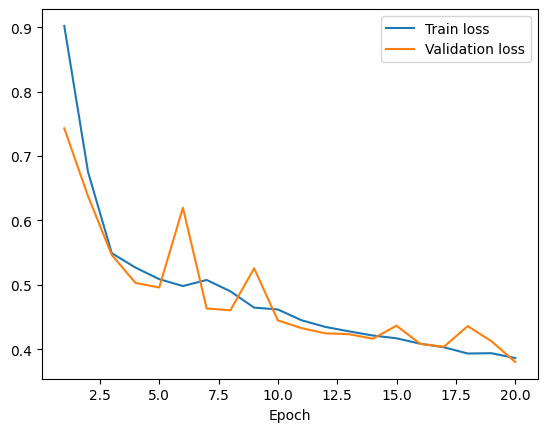

In [10]:
# Plot losses
epochs = [i+1 for i in range(20)]
plot(epochs, {"Train loss":train_losses, "Validation loss":val_losses})

Evaluate on test dataset

In [11]:

# Evaluate on test dataset
model = RNN().to(device)

# Data loader for test dataset
test_loader = DataLoader(ds_test, len(ds_test), shuffle=False)

with open("q2_rnn_best.model","rb") as file:
    model.load_state_dict(pickle.load(file))
    
test_corr = 0.0
for x, y, mask in test_loader:
        
    # Add channel dimension to x 
    x = x.unsqueeze(1)
    
    # Compute spearman correlation
    test_corr = masked_spearman_correlation( model(x), y, mask)
    
    # Break (single batch)
    break

print(f"Spearman correlation on test set is {test_corr}")
    


Spearman correlation on test set is 0.5882315039634705


Hyperparameters tuning

In [30]:
# Reconfigure seed
configure_seed(33)

# Grid
lr_vals = [1e-2, 1e-3, 1e-4]
wd_vals = [0, 1e-5]
dropout_vals = [0.3, 0.5]

# Keep track of best model in grid
best_model = {"val_corr":0}

# Device
device = "gpu" if torch.cuda.is_available() else "cpu"
            
# Grid search
for lr in lr_vals:
    for weight_decay in wd_vals:
        for dropout in dropout_vals:
            
            print(f"Combination: lr {lr}, weight decay {weight_decay}, dropout {dropout}")
            
            # Instantiate model
            model = RNN(dropout=dropout).to(device)
            
            # Train
            best_state, best_val_corr, train_losses, val_losses = train(model, 
                                                                        epochs=20, 
                                                                        batch_size=256, 
                                                                        lr=lr,
                                                                        ds_train=ds_train,
                                                                        ds_val=ds_val,
                                                                        weight_decay=weight_decay,
                                                                        verbose=False)
                                            
            print(f"Best validation correlation: {best_val_corr}")
            print("____________")
            
            if  best_val_corr > best_model["val_corr"]:
                best_model["val_corr"] = best_val_corr
                best_model["state"] = best_state
                best_model["train_losses"] = train_losses
                best_model["val_losses"] = val_losses
                best_model["config"] = (lr, weight_decay, dropout)

Combination: lr 0.01, weight decay 0, dropout 0.3
Best validation correlation: 0.5843817591667175
____________
Combination: lr 0.01, weight decay 0, dropout 0.5
Best validation correlation: 0.22707560658454895
____________
Combination: lr 0.01, weight decay 1e-05, dropout 0.3
Best validation correlation: 0.5842583775520325
____________
Combination: lr 0.01, weight decay 1e-05, dropout 0.5
Best validation correlation: 0.5999194979667664
____________
Combination: lr 0.001, weight decay 0, dropout 0.3
Best validation correlation: 0.6158115863800049
____________
Combination: lr 0.001, weight decay 0, dropout 0.5
Best validation correlation: 0.609386146068573
____________
Combination: lr 0.001, weight decay 1e-05, dropout 0.3
Best validation correlation: 0.5983884334564209
____________
Combination: lr 0.001, weight decay 1e-05, dropout 0.5
Best validation correlation: 0.6039701700210571
____________
Combination: lr 0.0001, weight decay 0, dropout 0.3
Best validation correlation: 0.494221001

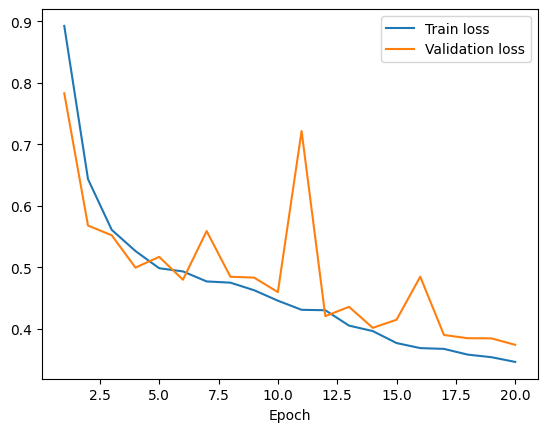

In [31]:
# Plots 
epochs = [i+1 for i in range(20)]

plot(epochs, {"Train loss":best_model["train_losses"], "Validation loss":best_model["val_losses"]})

In [15]:
# Evaluate on test dataset
model = RNN().to(device)

# Data loader for test dataset
test_loader = DataLoader(ds_test, len(ds_test), shuffle=False)

model.load_state_dict(best_model["state"])
    
test_corr = 0.0
for x, y, mask in test_loader:
        
    # Add channel dimension to x 
    x = x.unsqueeze(1)
    
    # Compute spearman correlation
    test_corr = masked_spearman_correlation( model(x), y, mask)
    
    # Break (single batch)
    break

print(f"Spearman correlation on test set is {test_corr}")
    


Spearman correlation on test set is 0.5855811238288879
